# Data Casal Montserratina

In [1]:
#Data Manipulation
import pandas as pd
import numpy as np
from datetime import timedelta

import os

# Plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# for EDA
from ydata_profiling import ProfileReport 

#Others
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose

#Parameters Dict
parameters = {
    "paths": {
        "2022_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202201_202206.csv",
        "2022_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202207_202212.csv",
        "2023_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202301_202306.csv",
        "2023_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202307_202312.csv",
        "2024_01_05": "../data/data_casal_montserratina/Casal_Montserratina_202401_202405.csv",
    }
}

# Funciones

In [2]:
def grafico_zoom(df_x, df_y, title="", xaxis_title="", yaxis_title=""):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df_x,  # x-axis
        y=df_y,  # y-axis
        mode='lines',  # Connect data points with lines
        name='Line',  # Name in the legend
        connectgaps=False  # Do not connect the gaps (NaN values)
    ))

    # Layout parameters
    fig.update_layout(
        title=title,  # Title
        xaxis_title=xaxis_title,  # x-axis name
        yaxis_title=yaxis_title,  # y-axis name
        xaxis_tickangle=0,  # Set the x-axis label angle
        showlegend=False  # Do not display the legend
    )

    fig.show()

In [3]:
#Prints the NaN Values per Column of a dataset
def checkNaNValues(df):
    return print(f"NaN Count per Column", df.isna().any(axis=1).sum())

In [4]:
#Checks if there is any missing time series
def checkMissingData(df, date_column):
    min_date = df[date_column].min()
    max_date = df[date_column].max()

    date_range = pd.date_range(start=min_date, end=max_date, freq='h')
    missing_dates = date_range[~date_range.isin(df[date_column])]
    print(f"Number of Missing Values: {missing_dates.shape[0]}")
    return None if missing_dates.shape[0] == 0 else missing_dates, date_range

In [5]:
def getNumberOfOutliersPerColumn(df, columns_list):
    for col in columns_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        #Calcular los límites inferiores y superiores para identificar outliers
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr

        outliers = ((df[col] < lim_inf) | (df[col] > lim_sup))
        print(f"For {col} Column, the Number of Outliers is {outliers.sum()}. Sus limites son {lim_inf} y {lim_sup}.\n")

In [6]:
def dataframe_slicer (df, fecha_inicial, fecha_final):
    """
    Recorta el DataFrame en base a una fecha inicial y otra final.

    Parameters:
    df (DataFrame): El DataFrame original que contiene los datos.
    fecha_inicial (str): La fecha inicial en formato 'YYYY-MM-DD HH:MM:SS'.
    fecha_final (str): La fecha final en formato 'YYYY-MM-DD HH:MM:SS'.

    Returns:
    DataFrame: Un nuevo DataFrame recortado.
    """
    # Convertir las columnas de fecha a datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Filtrar el DataFrame en base a las fechas
    df_recortado = df[(df['Date'] >= fecha_inicial) & (df['Date'] <= fecha_final)]
    
    return df_recortado

# Load Data

In [7]:
ruta_data = "../data/data_casal_montserratina/"

In [8]:
df1 = pd.read_csv(parameters["paths"]["2022_01_06"], delimiter=";")
df2 = pd.read_csv(parameters["paths"]["2022_07_12"], delimiter=";")
df3 = pd.read_csv(parameters["paths"]["2023_01_06"], delimiter=";")
df4 = pd.read_csv(parameters["paths"]["2023_07_12"], delimiter=";")
df5 = pd.read_csv(parameters["paths"]["2024_01_05"], delimiter=";")

In [9]:
# hago un concat de los 4 datasets, para Unir los DataFrames uno a continuación del otro
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

In [10]:
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], format="%d/%m/%Y %H:%M")
df.rename(columns={'TimeStamp': 'Date'}, inplace=True)
df.rename(columns={'Valor': 'Consumo'}, inplace=True)
df.rename(columns={'Període tarifari': 'Periode_tarifari'}, inplace=True)
df.rename(columns={'Tipus lectura': 'Tipus_lectura'}, inplace=True)

In [11]:
df

Date  Consumo  Periode_tarifari Tipus_lectura
0     2022-01-01 00:00:00        6                 6          Real
1     2022-01-01 01:00:00        6                 6          Real
2     2022-01-01 02:00:00        5                 6          Real
3     2022-01-01 03:00:00        7                 6          Real
4     2022-01-01 04:00:00        7                 6          Real
...                   ...      ...               ...           ...
17683 2024-05-07 19:00:00       10                 4          Real
17684 2024-05-07 20:00:00        7                 4          Real
17685 2024-05-07 21:00:00        4                 4          Real
17686 2024-05-07 22:00:00        2                 5          Real
17687 2024-05-07 23:00:00        2                 5          Real

[17688 rows x 4 columns]

# EDA

In [79]:
# # Generate the report
# profile = ProfileReport(df,title="monserratina_2022_2023", tsmode=True, sortby="Date", correlations={"auto": {"calculate": False}})

# # Save the report to .html
# # profile.to_file("monserratina_2022_2023.html")

# profile

In [80]:
# Elimino la columna "Tipo de Lectura" & "Periode Tarifari"
df = df.drop(columns=["Tipus_lectura", "Periode_tarifari"])

# Missing values

In [81]:
checkNaNValues(df)
missing_dates, date_range = checkMissingData(df, 'Date')

NaN Count per Column 0
Number of Missing Values: 2906


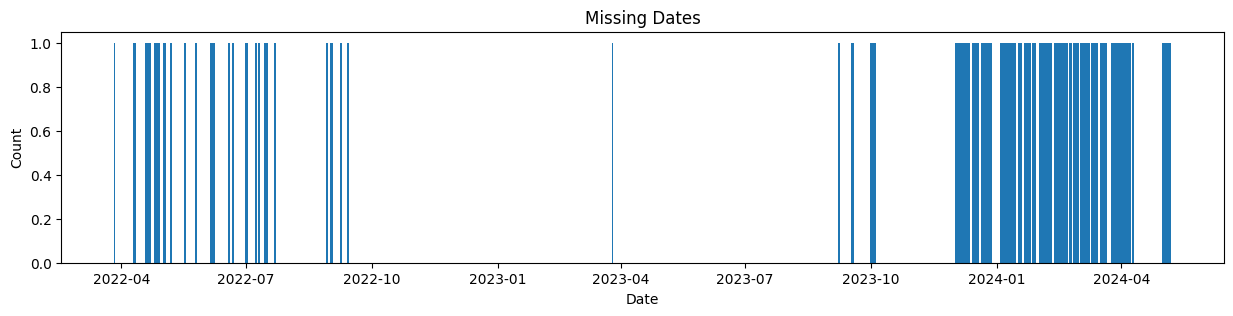

In [82]:
plt.figure(figsize=(15, 3))
plt.bar(missing_dates, [1] * len(missing_dates))
plt.title("Missing Dates")
plt.xlabel("Date")
plt.ylabel("Count")
# plt.xticks(rotation=0)
plt.show()

In [83]:
# un ejemplo de las fechas faltantes.

print(df[(df["Date"]>"2022-04-09 22:00:00") & (df["Date"]<"2022-04-11 01:00:00")])

# >>>>> notar que entre las 23 del 9/4 a las 00 del 11/4 no hay datos. 

                    Date  Consumo
2374 2022-04-09 23:00:00        2
2375 2022-04-11 00:00:00        2


### rellenar los huecos de Date

In [84]:
df = df.drop_duplicates(keep=False) # duplicados no hay, pero surgió un par de veces ese error al hacer e reindex. 

df.set_index("Date", inplace=True)

# Reindexa el DataFrame con el nuevo rango de fechas y rellena los valores faltantes con NaN
data_reindexed = df.reindex(date_range)

data_reindexed.reset_index(inplace=True)
data_reindexed.rename(columns={'index': 'Date'}, inplace=True) 

Ya no hay huecos en la columna Date, ahora aparecen rellenas!... con Nulls, tiny bam! 

In [85]:
print(data_reindexed[(data_reindexed["Date"]>"2022-04-09 22:00:00") & (data_reindexed["Date"]<"2022-04-11 01:00:00")])

                    Date  Consumo
2375 2022-04-09 23:00:00      2.0
2376 2022-04-10 00:00:00      NaN
2377 2022-04-10 01:00:00      NaN
2378 2022-04-10 02:00:00      NaN
2379 2022-04-10 03:00:00      NaN
2380 2022-04-10 04:00:00      NaN
2381 2022-04-10 05:00:00      NaN
2382 2022-04-10 06:00:00      NaN
2383 2022-04-10 07:00:00      NaN
2384 2022-04-10 08:00:00      NaN
2385 2022-04-10 09:00:00      NaN
2386 2022-04-10 10:00:00      NaN
2387 2022-04-10 11:00:00      NaN
2388 2022-04-10 12:00:00      NaN
2389 2022-04-10 13:00:00      NaN
2390 2022-04-10 14:00:00      NaN
2391 2022-04-10 15:00:00      NaN
2392 2022-04-10 16:00:00      NaN
2393 2022-04-10 17:00:00      NaN
2394 2022-04-10 18:00:00      NaN
2395 2022-04-10 19:00:00      NaN
2396 2022-04-10 20:00:00      NaN
2397 2022-04-10 21:00:00      NaN
2398 2022-04-10 22:00:00      NaN
2399 2022-04-10 23:00:00      NaN
2400 2022-04-11 00:00:00      2.0


In [86]:
grafico_zoom(data_reindexed["Date"], data_reindexed["Consumo"],
              "Consumo Eléctrico Casal La Monserratina - Años 2022, 2023 y 2024", "Consumo [kW]")

In [87]:
data_reindexed

Date  Consumo
0     2022-01-01 00:00:00      6.0
1     2022-01-01 01:00:00      6.0
2     2022-01-01 02:00:00      5.0
3     2022-01-01 03:00:00      7.0
4     2022-01-01 04:00:00      7.0
...                   ...      ...
20587 2024-05-07 19:00:00     10.0
20588 2024-05-07 20:00:00      7.0
20589 2024-05-07 21:00:00      4.0
20590 2024-05-07 22:00:00      2.0
20591 2024-05-07 23:00:00      2.0

[20592 rows x 2 columns]

In [88]:
getNumberOfOutliersPerColumn(data_reindexed, data_reindexed.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1980. Sus limites son -4.0 y 12.0.



c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Consumo', ylabel='Count'>

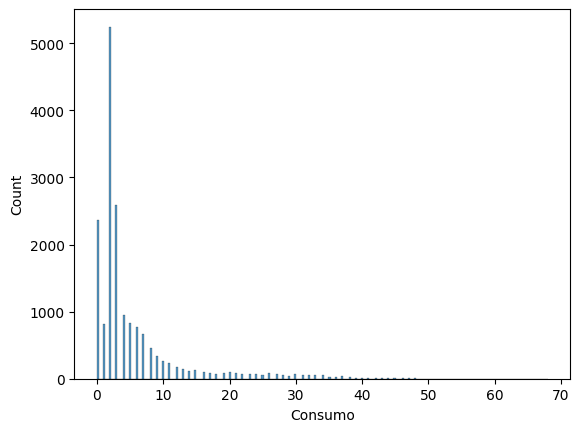

In [89]:
sns.histplot(data_reindexed, x="Consumo")

<Axes: xlabel='Consumo'>

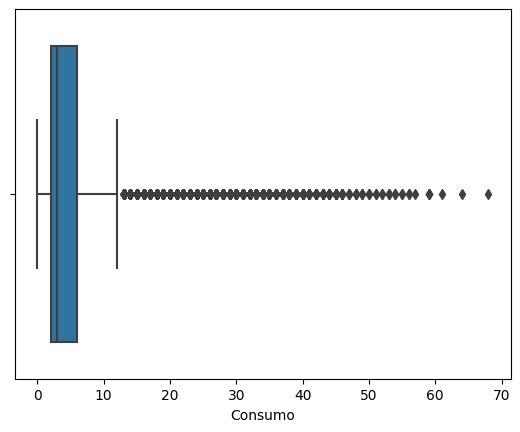

In [90]:
sns.boxplot(data_reindexed, x="Consumo" )

## Slice Dataset
la idea es quedarse solo con la zona central, dejando fuera los picos del inicio, y los huecos del final. 

In [91]:
# Definir las fechas inicial y final
fecha_inicial = '2022-07-01 00:00:00' # 'YYYY-MM-DD HH:MM:SS'.
fecha_final = '2023-11-30 23:00:00'

# Obtener el DataFrame recortado
df_sliced = dataframe_slicer(data_reindexed, fecha_inicial, fecha_final)

In [92]:

grafico_zoom(df_sliced["Date"], df_sliced["Consumo"],
              "Consumo Eléctrico (CON HUECOS) Casal La Monserratina - de Julio 2022 a Dic 2023 ", "Consumo [kW]")

### Outliers del df_sliced

In [93]:
getNumberOfOutliersPerColumn(df_sliced, df_sliced.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1306. Sus limites son -2.5 y 9.5.



<Axes: xlabel='Consumo'>

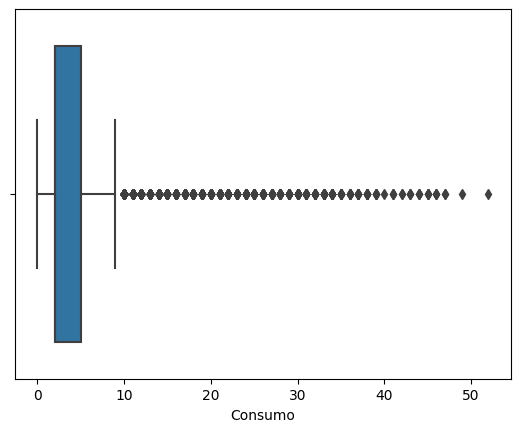

In [94]:
sns.boxplot(df_sliced, x="Consumo" )

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Consumo', ylabel='Count'>

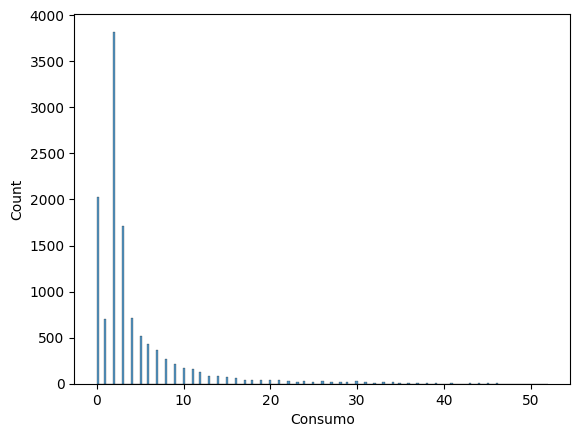

In [95]:
sns.histplot(df_sliced, x="Consumo")

## hago un smoothing w/moving average

In [96]:
from statsmodels.robust.scale import mad

# Define the window size for the rolling mean
window_size = 3 # datos horarios


# Calculate the rolling mean
df_sliced['Consumo_smooth_mean'] = df_sliced['Consumo'].rolling(window=window_size).mean()
#df_sliced['Consumo_smooth_std'] = df_sliced['Consumo'].rolling(window=window_size).std()
#df_sliced['Consumo_smooth_MAD'] = df_sliced['Consumo'].rolling(window=window_size).apply(mad)

C:\Users\afernandez\AppData\Local\Temp\ipykernel_16416\3317084542.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
# Create traces for original and smoothed data
trace_original = go.Scatter(x=df_sliced["Date"], y=df_sliced['Consumo'], mode='lines', name='Original')
trace_smoothed_mean = go.Scatter(x=df_sliced["Date"], y=df_sliced['Consumo_smooth_mean'], mode='lines', name='Smoothed Mean')

# Create layout
layout = go.Layout(title='Original vs Smoothed Data', xaxis=dict(title='Date'), yaxis=dict(title='Consumption [kW]'))

# Create figure
fig = go.Figure(data=[trace_original, trace_smoothed_mean], layout=layout)

# Show figure
fig.show()

el rooling average lo que hace es calcular una media variable de la ventana definida. en este caso son bloques horarios, ej: window_size=3 hace un promedio de las ultimas 3 horas (aun no se ha aplicado upsampling a 15 min). Si bien no es la mejor idea utilizar una variable modificada como funcion objetivo, pareciera que la curva resultante tiene mucho menos ruido y copia casi perfectamente la curva original.

### Outliers del smoothed DF

In [98]:
df_sliced.describe()

Date       Consumo  Consumo_smooth_mean
count                12432  12069.000000         12039.000000
mean   2023-03-16 23:30:00      4.259425             4.264308
min    2022-07-01 00:00:00      0.000000             0.000000
25%    2022-11-07 11:45:00      2.000000             2.000000
50%    2023-03-16 23:30:00      2.000000             2.333333
75%    2023-07-24 11:15:00      5.000000             5.000000
max    2023-11-30 23:00:00     52.000000            47.666667
std                    NaN      5.815219             5.268905

In [99]:
getNumberOfOutliersPerColumn(df_sliced, df_sliced.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1306. Sus limites son -2.5 y 9.5.

For Consumo_smooth_mean Column, the Number of Outliers is 1231. Sus limites son -2.5 y 9.5.



<Axes: xlabel='Consumo_smooth_mean'>

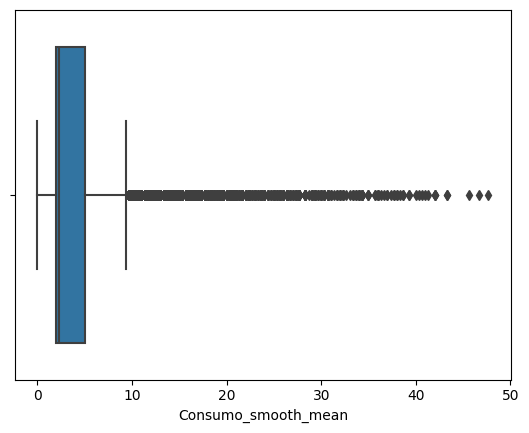

In [100]:
sns.boxplot(df_sliced, x="Consumo_smooth_mean")

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Consumo_smooth_mean', ylabel='Count'>

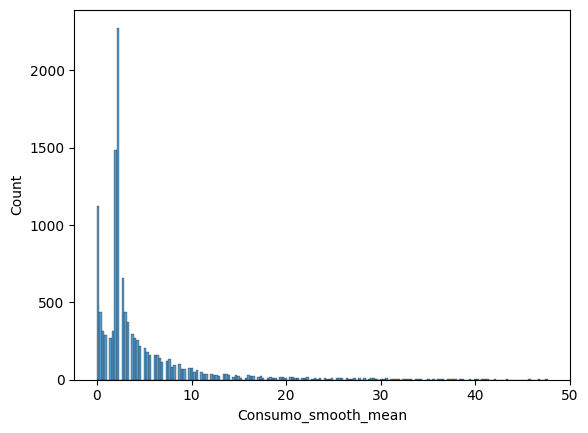

In [101]:
sns.histplot(df_sliced, x="Consumo_smooth_mean")

# upsampling a 15 min

In [102]:
df_upsampled = df_sliced.copy()

In [103]:
df_upsampled.set_index("Date", inplace=True)

In [104]:
df_upsampled = df_upsampled.resample('15min').interpolate(method='time')
df_upsampled

Consumo  Consumo_smooth_mean
Date                                             
2022-07-01 00:00:00      NaN                  NaN
2022-07-01 00:15:00      NaN                  NaN
2022-07-01 00:30:00      NaN                  NaN
2022-07-01 00:45:00      NaN                  NaN
2022-07-01 01:00:00      NaN                  NaN
...                      ...                  ...
2023-11-30 22:00:00      2.0             3.666667
2023-11-30 22:15:00      2.0             3.416667
2023-11-30 22:30:00      2.0             3.166667
2023-11-30 22:45:00      2.0             2.916667
2023-11-30 23:00:00      2.0             2.666667

[49725 rows x 2 columns]

# Merge Consumo con PPV

In [105]:
# Load the DataFrame from the pickle file
nombre_archivo = "LaMonserratina_weather_&_PV_2022_2023.pkl"
df_PV = pd.read_pickle(os.path.join(ruta_data, nombre_archivo))
df_PV.rename(columns={"timestamp_local": "Date"}, inplace=True)
#df_PV.set_index("Date", inplace=True)


In [106]:
df_PV.rename(columns={'pres [mb]':'pres_mb', 'slp [mb]':"slp_mb", 'wind_dir [m/s]':'wind_dir_m/s',
       'wind_gust_spd [m/s]':'wind_gust_spd_m/s', 'wind_spd [m/s]':'wind_spd_m/s', 'temp [C]':'temp_C', 
       'app_temp [C]':'app_temp_C', 'rh [%]':'rh_%', 'dewpt [C]':'dewpt_C', 'clouds [%]':'clouds_%', 
       'vis [Km]':'vis_Km', 'precip [mm]':'precip_mm', 'dhi [W/m^2]':'dhi_W/m2', 'dni [W/m^2]':'dni_W/m2', 
       'ghi [W/m^2]':'ghi_W/m2', 'solar_rad [W/m^2]':'solar_rad_W/m2','uv [0-11+]':'uv_0-11', 
       'elev_angle [º]':'elev_angle_º', 'azimuth [º]':'azimuth_º','Temp interna Modulo [C]':'Temp interna Modulo_C'}, inplace=True)

In [107]:
df_PV.head(3)

Date  pres_mb  slp_mb  wind_dir_m/s  wind_gust_spd_m/s  \
0 2022-01-01 00:00:00   1027.0  1028.0         360.0                4.0   
1 2022-01-01 00:15:00   1027.0  1028.0         357.5                4.1   
2 2022-01-01 00:30:00   1027.0  1028.0         355.0                4.2   

   wind_spd_m/s  temp_C  app_temp_C  rh_%  dewpt_C  ...   PV  \
0           1.0    10.7        10.7  92.0    9.500  ...  0.0   
1           1.4    10.7        10.7  91.0    9.325  ...  0.0   
2           1.8    10.7        10.7  90.0    9.150  ...  0.0   

   Temp interna Modulo_C  PV Wh  Year  Month  Hour  DayOfWeek  DayOfYear  Day  \
0              22.066196    0.0  2022      1     0          5          1    1   
1              22.066196    0.0  2022      1     0          5          1    1   
2              22.066196    0.0  2022      1     0          5          1    1   

   Minute  
0       0  
1      15  
2      30  

[3 rows x 31 columns]

In [108]:
checkNaNValues(df_PV)
missing_dates, date_range = checkMissingData(df_PV, 'Date')

NaN Count per Column 0
Number of Missing Values: 0


In [119]:
#df3.set_index("Date", inplace=True)


df_upsampled.rename(columns={"Consumo": "Consumo_kW"}, inplace=True)
df_upsampled.rename(columns={"Consumo_smooth_mean": "Consumo_smooth_mean_kW"}, inplace=True)

df_upsampled.reset_index(inplace=True)
df3.drop(columns=["index"], inplace=True)
df_upsampled.head(3)

ValueError: cannot insert level_0, already exists

In [115]:
df4 = df3.merge(df_PV, how="inner", on=["Date", "Date"])

KeyError: 'Date'

hay un probma con las unidades, Consumo de Red esta en kW, y PV en W.. ajusto PV/1000. y agrego las unidades a los nombres para evitar confusiones

In [ ]:
df4.rename(columns={'Consumo [kW]': 'Consumo_red [kW]'}, inplace=True)

df4["PV [kW]"] = (df4["PV"]/1000000).round(3)
df4.drop(columns=["PV"], inplace=True)

In [ ]:
df4["Consumo_total [kW]"] = df4["Consumo_red [kW]"] + df4["PV [kW]"]

In [ ]:
df4.sample(10)

Date  Consumo_red [kW]  pres [mb]  slp [mb]  \
29889 2022-11-08 08:15:00          3.750000    1016.00   1016.25   
15219 2022-06-08 12:45:00         28.500000    1011.00   1012.00   
24682 2022-09-15 02:30:00          2.000000    1009.00   1009.50   
57211 2023-08-19 22:45:00          2.000000    1017.00   1017.75   
68909 2023-12-19 19:15:00         24.750000    1024.00   1024.75   
56828 2023-08-15 23:00:00          3.000000    1015.00   1015.00   
79136 2024-04-04 08:00:00          3.000000    1018.00   1019.00   
70515 2024-01-05 12:45:00          5.819546    1001.25   1002.25   
41455 2023-03-08 19:45:00          7.250000    1007.00   1008.00   
42878 2023-03-23 15:30:00          0.000000    1014.00   1014.50   

       wind_dir [m/s]  wind_gust_spd [m/s]  wind_spd [m/s]  temp [C]  \
29889           272.5                8.075          2.7250    13.150   
15219           220.0                6.500          5.7975    25.225   
24682           355.0                5.200          3.5950    23.200   
57211            87.5                1.425          1.2750    26.925   
68909            92.5                4.200          1.8975    11.575   
56828            70.0                4.800          3.6000    26.700   
79136           360.0                3.600          3.6000    11.400   
70515           352.5                6.975          5.1750    13.450   
41455           235.0                7.400          4.2150    15.525   
42878           230.0                8.095          7.6950    15.550   

       app_temp [C]  rh [%]  ...         PV Wh  Year  Month  Hour  DayOfWeek  \
29889        13.150   78.75  ...  1.942827e+06  2022     11     8          1   
15219        25.700   71.25  ...  4.588745e+06  2022      6    12          2   
24682        23.600   77.50  ...  0.000000e+00  2022      9     2          3   
57211        29.750   82.00  ...  0.000000e+00  2023      8    22          5   
68909        11.575   48.25  ...  0.000000e+00  2023     12    19          1   
56828        29.400   84.00  ...  0.000000e+00  2023      8    23          1   
79136        11.400   75.00  ...  1.717018e+06  2024      4     8          3   
70515        13.450   67.25  ...  4.161180e+06  2024      1    12          4   
41455        15.525   64.50  ...  0.000000e+00  2023      3    19          2   
42878        15.550   77.00  ...  4.441475e+06  2023      3    15          3   

       DayOfYear  Day  Minute  PV [kW]  Consumo_total [kW]  
29889        312    8      15    1.943            5.693000  
15219        159    8      45    4.589           33.089000  
24682        258   15      30    0.000            2.000000  
57211        231   19      45    0.000            2.000000  
68909        353   19      15    0.000           24.750000  
56828        227   15       0    0.000            3.000000  
79136         95    4       0    1.717            4.717000  
70515          5    5      45    4.161            9.980546  
41455         67    8      45    0.000            7.250000  
42878         82   23      30    4.441            4.441000  

[10 rows x 33 columns]

## add some extra exogenous variables columns

In [ ]:
# #Generate a new column called Hour_sen and Hour_cos, wich is the hour 
# #transformed by the sine and cosine function
# def generateSinCosHour(df):
#     df['Hour_sen'] = np.sin((df['Hour'] / 24) * np.pi * 2)  # = SIN((A1*PI())/24)
#     df['Hour_cos'] = np.cos((df['Hour'] / 24) * np.pi * 2)
#     return df

In [ ]:
#Sine and Cosine Transformations
def cyclical_encoding(df, cycle_length_list, columns):
    for col, cycle_length in zip(columns, cycle_length_list):
        if df[col].min == 0:
            df[f"{col}_sin"] = np.sin((df[col] / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos((df[col] / cycle_length) * np.pi * 2).round(4)
        else:
            df[f"{col}_sin"] = np.sin(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
    return df

In [ ]:
df5 = df4.copy()

#Add Demand 7 days before Column
df5["Consumo_total [kW]_-7d"] = df5["Consumo_total [kW]"].shift(7 * 96).fillna(0)

#Add isWeekend Column based in DayOfTheWeek Value
df5["isWeekend"] = df5["DayOfWeek"].isin([5, 6])

# #Generate Sin and Cos Transformations
# df5 = generateSinCosHour(df5)

cycle_lengths = [24, 7, 12, 365]
cols = ["Hour", "DayOfWeek", "Month", "DayOfYear"]

df5 = cyclical_encoding(df5, cycle_lengths, cols)

df5.sample(5)

Date  Consumo_red [kW]  pres [mb]  slp [mb]  \
57238 2023-08-20 05:30:00          2.500000     1016.0   1017.00   
79236 2024-04-05 09:00:00          7.152269     1020.0   1020.00   
8242  2022-03-27 20:30:00          2.500000     1024.0   1025.00   
24985 2022-09-18 06:15:00          2.000000     1015.0   1015.25   
21098 2022-08-08 18:30:00          0.500000     1014.0   1015.00   

       wind_dir [m/s]  wind_gust_spd [m/s]  wind_spd [m/s]  temp [C]  \
57238           320.0                  3.0           1.500    24.600   
79236            10.0                  3.2           2.100    13.400   
8242             80.0                  7.2           5.395    15.200   
24985           142.5                  6.4           2.225    20.875   
21098           180.0                  5.4           2.850    30.400   

       app_temp [C]  rh [%]  ...  Consumo_total [kW]_-7d  isWeekend  Hour_sin  \
57238        25.250   80.50  ...                2.000000       True    0.8660   
79236        13.400   82.00  ...               11.157269      False    0.8660   
8242         15.200   64.00  ...                2.500000       True   -0.9659   
24985        20.225   47.25  ...                2.000000       True    0.9659   
21098        32.000   52.00  ...                3.756000      False   -0.9659   

       Hour_cos  DayOfWeek_sin  DayOfWeek_cos  Month_sin  Month_cos  \
57238    0.5000        -0.9749        -0.2225     -0.500     -0.866   
79236   -0.5000         0.4339        -0.9010      1.000      0.000   
8242     0.2588        -0.9749        -0.2225      0.866      0.500   
24985    0.2588        -0.9749        -0.2225     -0.866     -0.500   
21098   -0.2588        -0.7818         0.6235     -0.500     -0.866   

       DayOfYear_sin  DayOfYear_cos  
57238        -0.7412        -0.6713  
79236         0.9979        -0.0645  
8242          0.9942         0.1074  
24985        -0.9721        -0.2345  
21098        -0.5878        -0.8090  

[5 rows x 43 columns]

In [ ]:
# df5 = df4.copy()

# #Add Demand 7 days before Column
# df5["Consumo_total [kW]_-7d"] = df5["Consumo_total [kW]"].shift(7 * 96).fillna(0)

# #Add isWeekend Column based in DayOfTheWeek Value
# df5["isWeekend"] = df5["DayOfWeek"].isin([5, 6])

# #Generate Sin and Cos Transformations
# df5 = generateSinCosHour(df5)

# df5.sample(5)

In [ ]:
#Add Demand 7 days before Column
df5["Consumo_total [kW]_-24h"] = df5["Consumo_total [kW]"].shift(96).fillna(0)

In [ ]:
# #Add Demand 24 hours before Column 
# def getDayBeforeDemand(df, row):
#     date = row["Date"]
#     counter, demand_24h = 0, 0
#     if row.isWeekend:
#         while counter < 7:
#             date -= timedelta(days=1)
#             row_24h = df.loc[df["Date"] == date]
#             if not row_24h.empty:
#                 row_24h = row_24h.iloc[[0]].squeeze()
#                 if row_24h["isWeekend"]:
#                     demand_24h = row_24h["Consumo_total [kW]"]
#                     break
#             counter += 1
#     else:
#         while counter < 7:
#             date -= timedelta(days=1)
#             row_24h = df.loc[df["Date"] == date]
#             if not row_24h.empty:
#                 row_24h = row_24h.iloc[[0]].squeeze()
#                 if row_24h["isWeekend"]:
#                     demand_24h = row_24h["Consumo_total [kW]"]
#                     break
#             counter += 1
#     return demand_24h

# df5["Demand_24h"] = df5.apply(
#     lambda row: getDayBeforeDemand(df5, row), axis=1)

In [ ]:
def generateHolidayVar(df):
    df["Reduced_Date"] = df["Date"].dt.date
    list_holidays = holidays.Spain(prov="CT", years=list(df["Year"].unique()))
    list_holidays_dates = np.array(list(list_holidays.keys()), dtype='datetime64')
    df["isHoliday"] = df["Reduced_Date"].isin(list_holidays_dates)
    df = df.drop('Reduced_Date', axis=1)
    return df

df5 = generateHolidayVar(df5)
display(df5[["Date", "isHoliday"]].sample(5))

Date  isHoliday
45232 2023-04-17 04:00:00      False
6590  2022-03-10 15:30:00      False
65442 2023-11-13 16:30:00      False
72498 2024-01-26 04:30:00      False
41050 2023-03-04 14:30:00      False

# Plots

## Demand Distribution Plots

In [111]:
sns.histplot(df5["Consumo_total_kW"])

KeyError: 'Consumo_total_kW'

Text(0.5, 0.98, '')

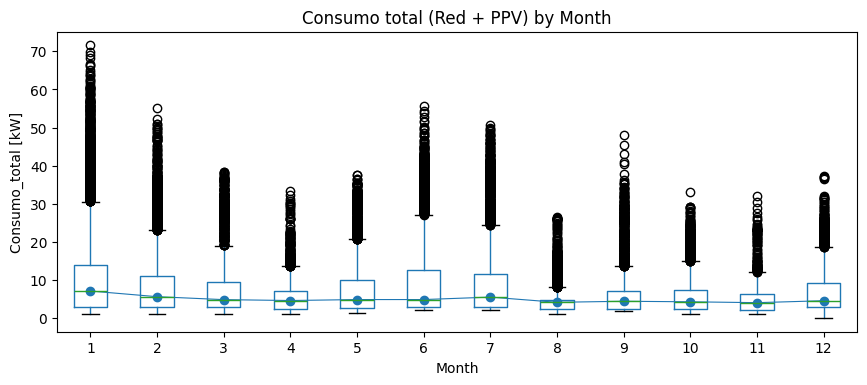

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_total [kW]', by='Month', ax=ax)
df5.groupby('Month')['Consumo_total [kW]'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Consumo_total [kW]')
ax.set_title("Consumo total (Red + PPV) by Month")
fig.suptitle('')

KeyError: 'Day'

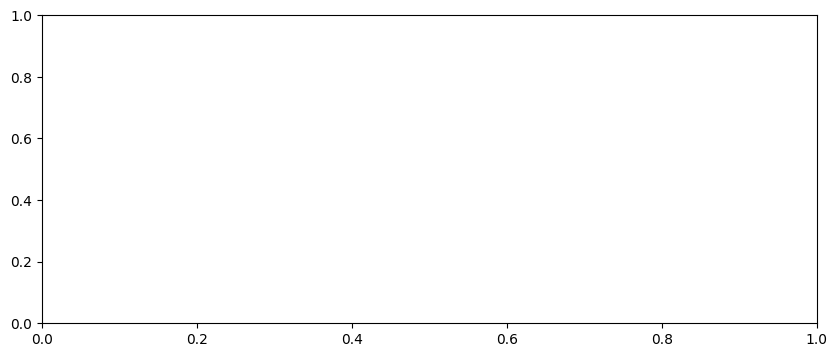

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_total [kW]', by='Day', ax=ax)
df5.groupby('Day')['Consumo_total [kW]'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Consumo_total [kW]')
ax.set_title("Consumo total (Red + PPV) by Day")
fig.suptitle('')

KeyError: 'Hour'

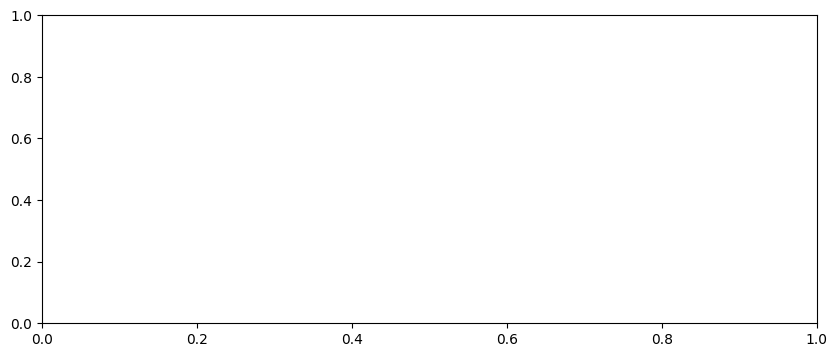

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_total [kW]', by='Hour', ax=ax)
df5.groupby('Hour')['Consumo_total [kW]'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title("Consumo total, por Horas")
fig.suptitle('')

In [ ]:
# # Weekly Demand Plot
# whole_df.set_index('Date', inplace=True)
# whole_df_1w = whole_df.resample('1W').mean()
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=whole_df_1w.index, y=whole_df_1w["Demand"], mode='lines'))
# fig.update_layout(
#     title = "Weekly Energy Demand",
#     xaxis_title = "Date",
#     yaxis_title = "Demand (MWh)",
#     width = 850,
#     height = 400,
#     margin=dict(l=20, r=20, t=35, b=20),
#     legend=dict(
#         orientation="h",
#         yanchor="top",
#         y=1,
#         xanchor="left",
#         x=0.001
#     )
# )
# fig.show()

#### Demand per Day and Season

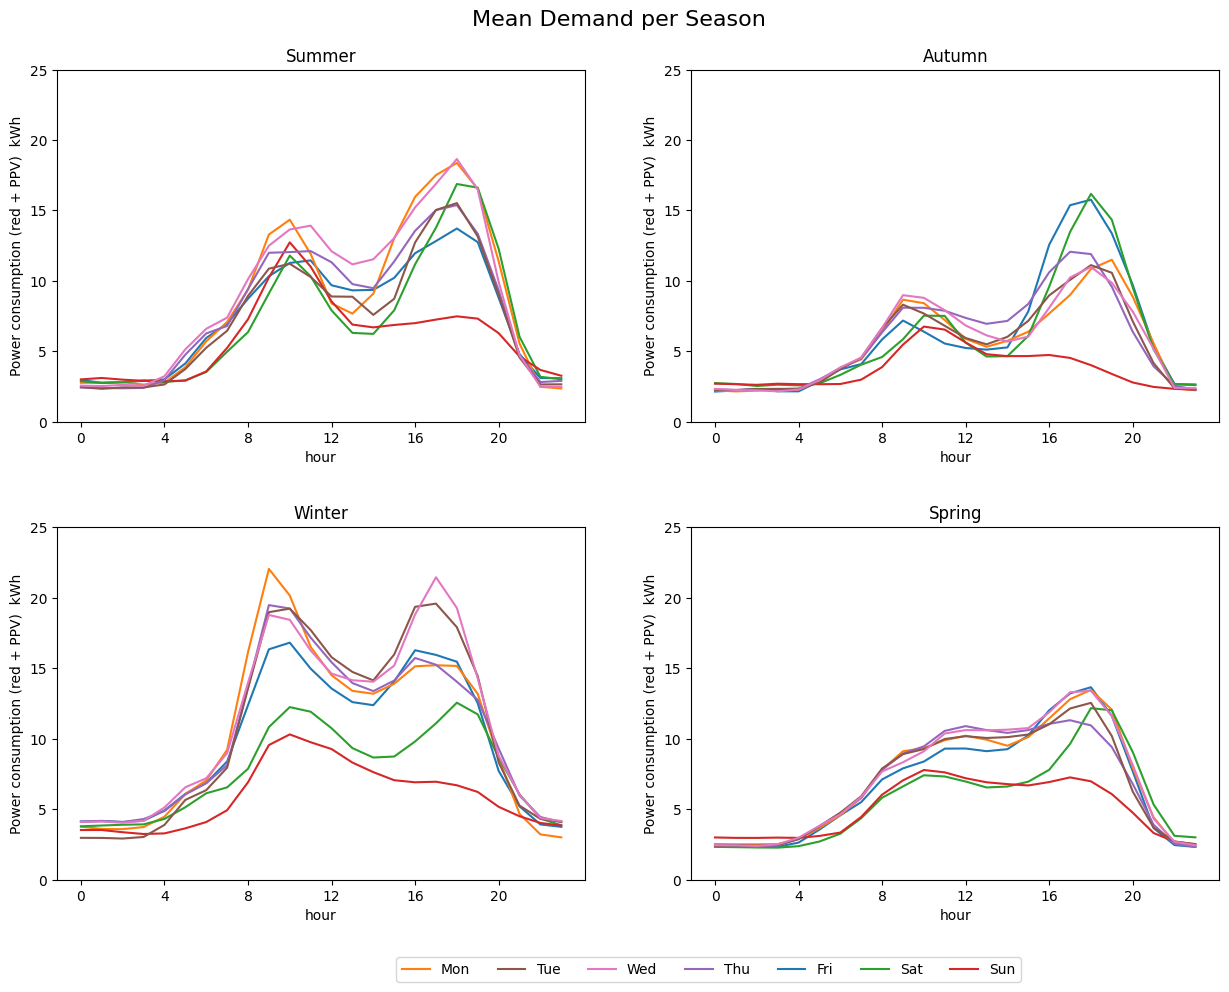

In [ ]:
days_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df5["Day"] = df5["DayOfWeek"].map(days_mapping)
df5["Season"] = df5["Month"].apply(
    lambda x: (
        1 if x in [3, 4, 5] #Spring
        else 2 if x in [6, 7, 8] #Summer
        else 3 if x in [9, 10, 11] #Autumn
        else 0 #Winter
    )
)
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.3, top=0.92)
fig.suptitle("Mean Demand per Season", fontsize=16)

fig.set_figheight(10)
fig.set_figwidth(15)

ymin, ymax = 0, 25

#Season Summer
df5.loc[df5["Season"] == 2] \
    .groupby([df5.loc[df5["Season"] == 2]["Hour"], 'Day'])["Consumo_total [kW]"].mean().unstack().plot(
        ax=axes[0, 0], ylim=(ymin, ymax), title="Summer", legend=False
    )
df5.loc[df5["Season"] == 3] \
    .groupby([df5.loc[df5["Season"] == 3]["Hour"], 'Day'])["Consumo_total [kW]"].mean().unstack().plot(
        ax=axes[0, 1], ylim=(ymin, ymax), title="Autumn", legend=False
    )
df5.loc[df5["Season"] == 0] \
    .groupby([df5.loc[df5["Season"] == 0]["Hour"], 'Day'])["Consumo_total [kW]"].mean().unstack().plot(
        ax=axes[1, 0], ylim=(ymin, ymax), title="Winter", legend=False
    )
df5.loc[df5["Season"] == 1] \
    .groupby([df5.loc[df5["Season"] == 1]["Hour"], 'Day'])["Consumo_total [kW]"].mean().unstack().plot(
        ax=axes[1, 1], ylim=(ymin, ymax), title="Spring", legend=False
    )

for ax in axes.flat:
    ax.set(xlabel='hour', ylabel='Power consumption (red + PPV)  kWh')

for n in range(0, 2):
    axes[n, 0].set_xticks([0, 4, 8, 12, 16, 20])
    axes[n, 1].set_xticks([0, 4, 8, 12, 16, 20])
df5 = df5.drop("Day", axis=1)
# LEGEND
handles, labels = plt.gca().get_legend_handles_labels() # reorder Legend Labels
order = [1,5,6,4,0,2,3]      # specify order in Legend
axes[1,1].legend([handles[i] for i in order], [labels[i] for i in order], loc=1, ncol=7, 
                 bbox_to_anchor=(0.638,-0.2), frameon=True) # print and order LEGEND

Text(0.5, 0.98, '')

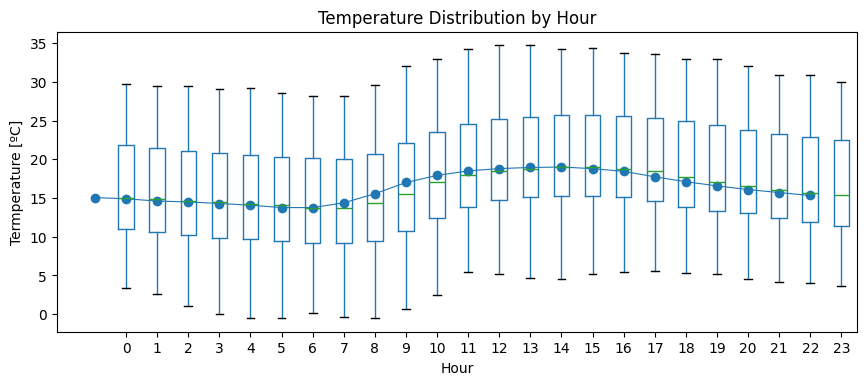

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='temp [C]', by='Hour', ax=ax)
df5.groupby('Hour')['temp [C]'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Termperature [ºC]')
ax.set_title("Temperature Distribution by Hour")
fig.suptitle('')

Text(0.5, 0.98, '')

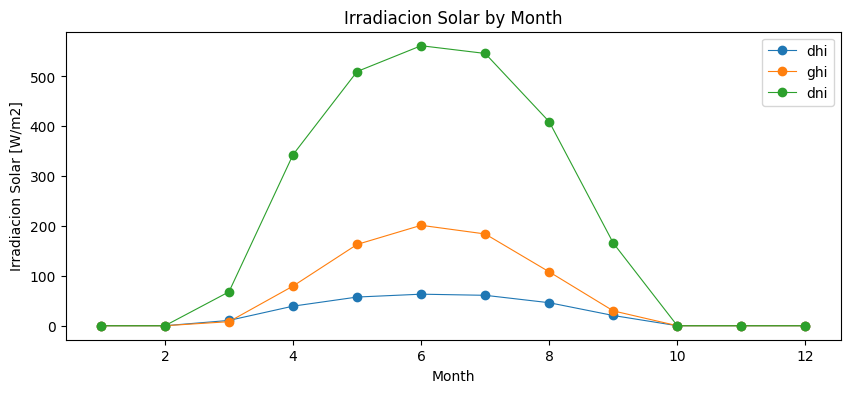

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

# df_PV.boxplot(column='dhi [W/m^2]', by='Month', ax=ax)
df_PV.groupby('Month')['dhi [W/m^2]'].median().plot(style='o-', linewidth=.8, ax=ax)

# df_PV.boxplot(column='ghi [W/m^2]', by='Month', ax=ax)
df_PV.groupby('Month')['ghi [W/m^2]'].median().plot(style='o-', linewidth=.8, ax=ax)

# df_PV.boxplot(column='dni [W/m^2]', by='Month', ax=ax)
df_PV.groupby('Month')['dni [W/m^2]'].median().plot(style='o-', linewidth=.8, ax=ax)

ax.legend(['dhi', 'ghi', 'dni'])

# dhi                      Irradiancia solar difusa en el plano horizontal    W/m2 [Clear Sky] 
# ghi                      Irradiancia solar global en el plano horizontal    W/m2 [Clear Sky] 
# dni                      Irradiancia solar directa normal                   W/m2 [Clear Sky] 

ax.set_ylabel('Irradiacion Solar [W/m2]')
ax.set_title("Irradiacion Solar by Month")
fig.suptitle('')

Text(0.5, 0.98, '')

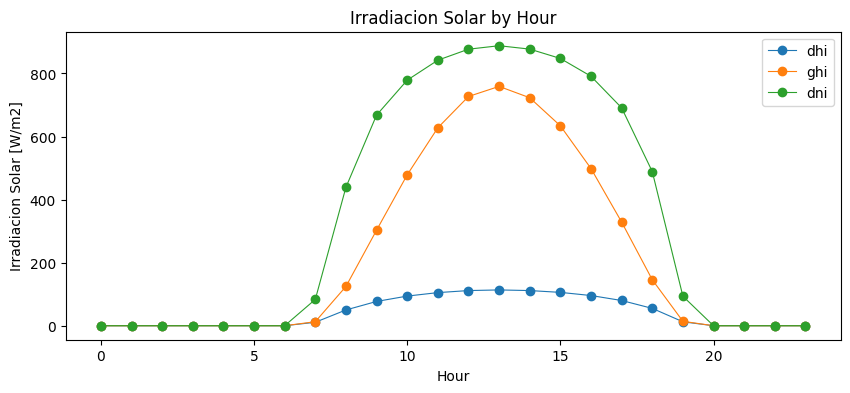

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

# df_PV.boxplot(column='dhi [W/m^2]', by='Hour', ax=ax)
df_PV.groupby('Hour')['dhi [W/m^2]'].median().plot(style='o-', linewidth=.8, ax=ax)

# df_PV.boxplot(column='ghi [W/m^2]', by='Hour', ax=ax)
df_PV.groupby('Hour')['ghi [W/m^2]'].median().plot(style='o-', linewidth=.8, ax=ax)

# df_PV.boxplot(column='dni [W/m^2]', by='Hour', ax=ax)
df_PV.groupby('Hour')['dni [W/m^2]'].median().plot(style='o-', linewidth=.8, ax=ax)

ax.legend(['dhi', 'ghi', 'dni'])

# dhi                      Irradiancia solar difusa en el plano horizontal    W/m2 [Clear Sky] 
# ghi                      Irradiancia solar global en el plano horizontal    W/m2 [Clear Sky] 
# dni                      Irradiancia solar directa normal                   W/m2 [Clear Sky] 

ax.set_ylabel('Irradiacion Solar [W/m2]')
ax.set_title("Irradiacion Solar by Hour")
fig.suptitle('')

## AutoCorrelation Plots

In [ ]:
df5.head()

Date  Consumo_red [kW]  pres [mb]  slp [mb]  wind_dir [m/s]  \
0 2022-01-01 00:00:00               6.0     1027.0    1028.0           360.0   
1 2022-01-01 00:15:00               6.0     1027.0    1028.0           357.5   
2 2022-01-01 00:30:00               6.0     1027.0    1028.0           355.0   
3 2022-01-01 00:45:00               6.0     1027.0    1028.0           352.5   
4 2022-01-01 01:00:00               6.0     1027.0    1028.0           350.0   

   wind_gust_spd [m/s]  wind_spd [m/s]  temp [C]  app_temp [C]  rh [%]  ...  \
0                  4.0             1.0      10.7          10.7    92.0  ...   
1                  4.1             1.4      10.7          10.7    91.0  ...   
2                  4.2             1.8      10.7          10.7    90.0  ...   
3                  4.3             2.2      10.7          10.7    89.0  ...   
4                  4.4             2.6      10.7          10.7    88.0  ...   

   Hour_cos  DayOfWeek_sin  DayOfWeek_cos  Month_sin  Month_cos  \
0    0.9659        -0.4339         -0.901        0.0        1.0   
1    0.9659        -0.4339         -0.901        0.0        1.0   
2    0.9659        -0.4339         -0.901        0.0        1.0   
3    0.9659        -0.4339         -0.901        0.0        1.0   
4    1.0000        -0.4339         -0.901        0.0        1.0   

   DayOfYear_sin  DayOfYear_cos  Consumo_total [kW]_-24h  isHoliday  Season  
0            0.0            1.0                      0.0       True       0  
1            0.0            1.0                      0.0       True       0  
2            0.0            1.0                      0.0       True       0  
3            0.0            1.0                      0.0       True       0  
4            0.0            1.0                      0.0       True       0  

[5 rows x 45 columns]

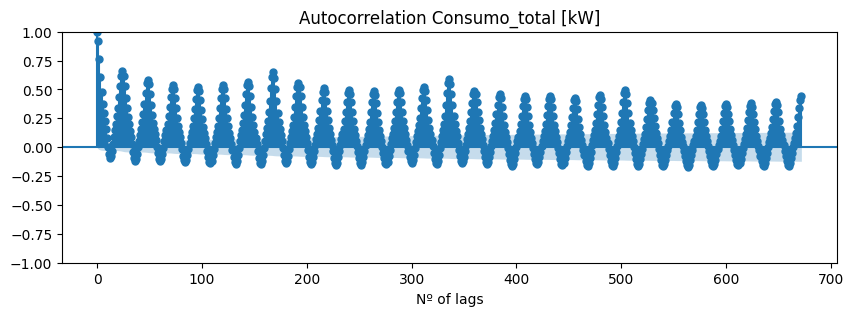

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
#Gráfico de autocorrelación 1
dfAutocorr = df5.copy()
dfAutocorr.set_index("Date", inplace=True)

dfAutocorr = dfAutocorr.resample('1h').mean()
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº of lags")

plot_acf(dfAutocorr["Consumo_total [kW]"], ax=ax, lags=24*7*4)
plt.title("Autocorrelation Consumo_total [kW]")
plt.show()

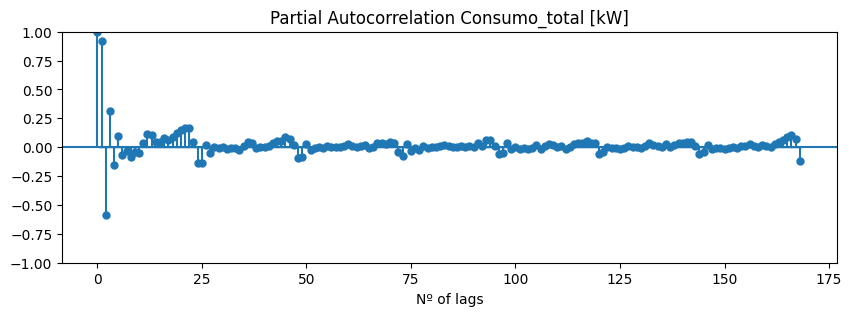

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
#Gráfico de autocorrelación parcial
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº of lags")
plot_pacf(dfAutocorr["Consumo_total [kW]"], ax=ax, lags=24*7)
plt.title("Partial Autocorrelation Consumo_total [kW]")
plt.show()

## Correlation Matrix

In [ ]:
df5.columns

Index(['Date', 'Consumo_red [kW]', 'pres [mb]', 'slp [mb]', 'wind_dir [m/s]',
       'wind_gust_spd [m/s]', 'wind_spd [m/s]', 'temp [C]', 'app_temp [C]',
       'rh [%]', 'dewpt [C]', 'clouds [%]', 'vis [Km]', 'precip [mm]',
       'dhi [W/m^2]', 'dni [W/m^2]', 'ghi [W/m^2]', 'solar_rad [W/m^2]',
       'uv [0-11+]', 'elev_angle [º]', 'azimuth [º]', 'Temp interna Modulo',
       'Temp interna Modulo [C]', 'PV Wh', 'Year', 'Month', 'Hour',
       'DayOfWeek', 'DayOfYear', 'Minute', 'PV [kW]', 'Consumo_total [kW]',
       'Consumo_total [kW]_-7d', 'isWeekend', 'Hour_sin', 'Hour_cos',
       'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos',
       'DayOfYear_sin', 'DayOfYear_cos', 'Consumo_total [kW]_-24h',
       'isHoliday', 'Season'],
      dtype='object')

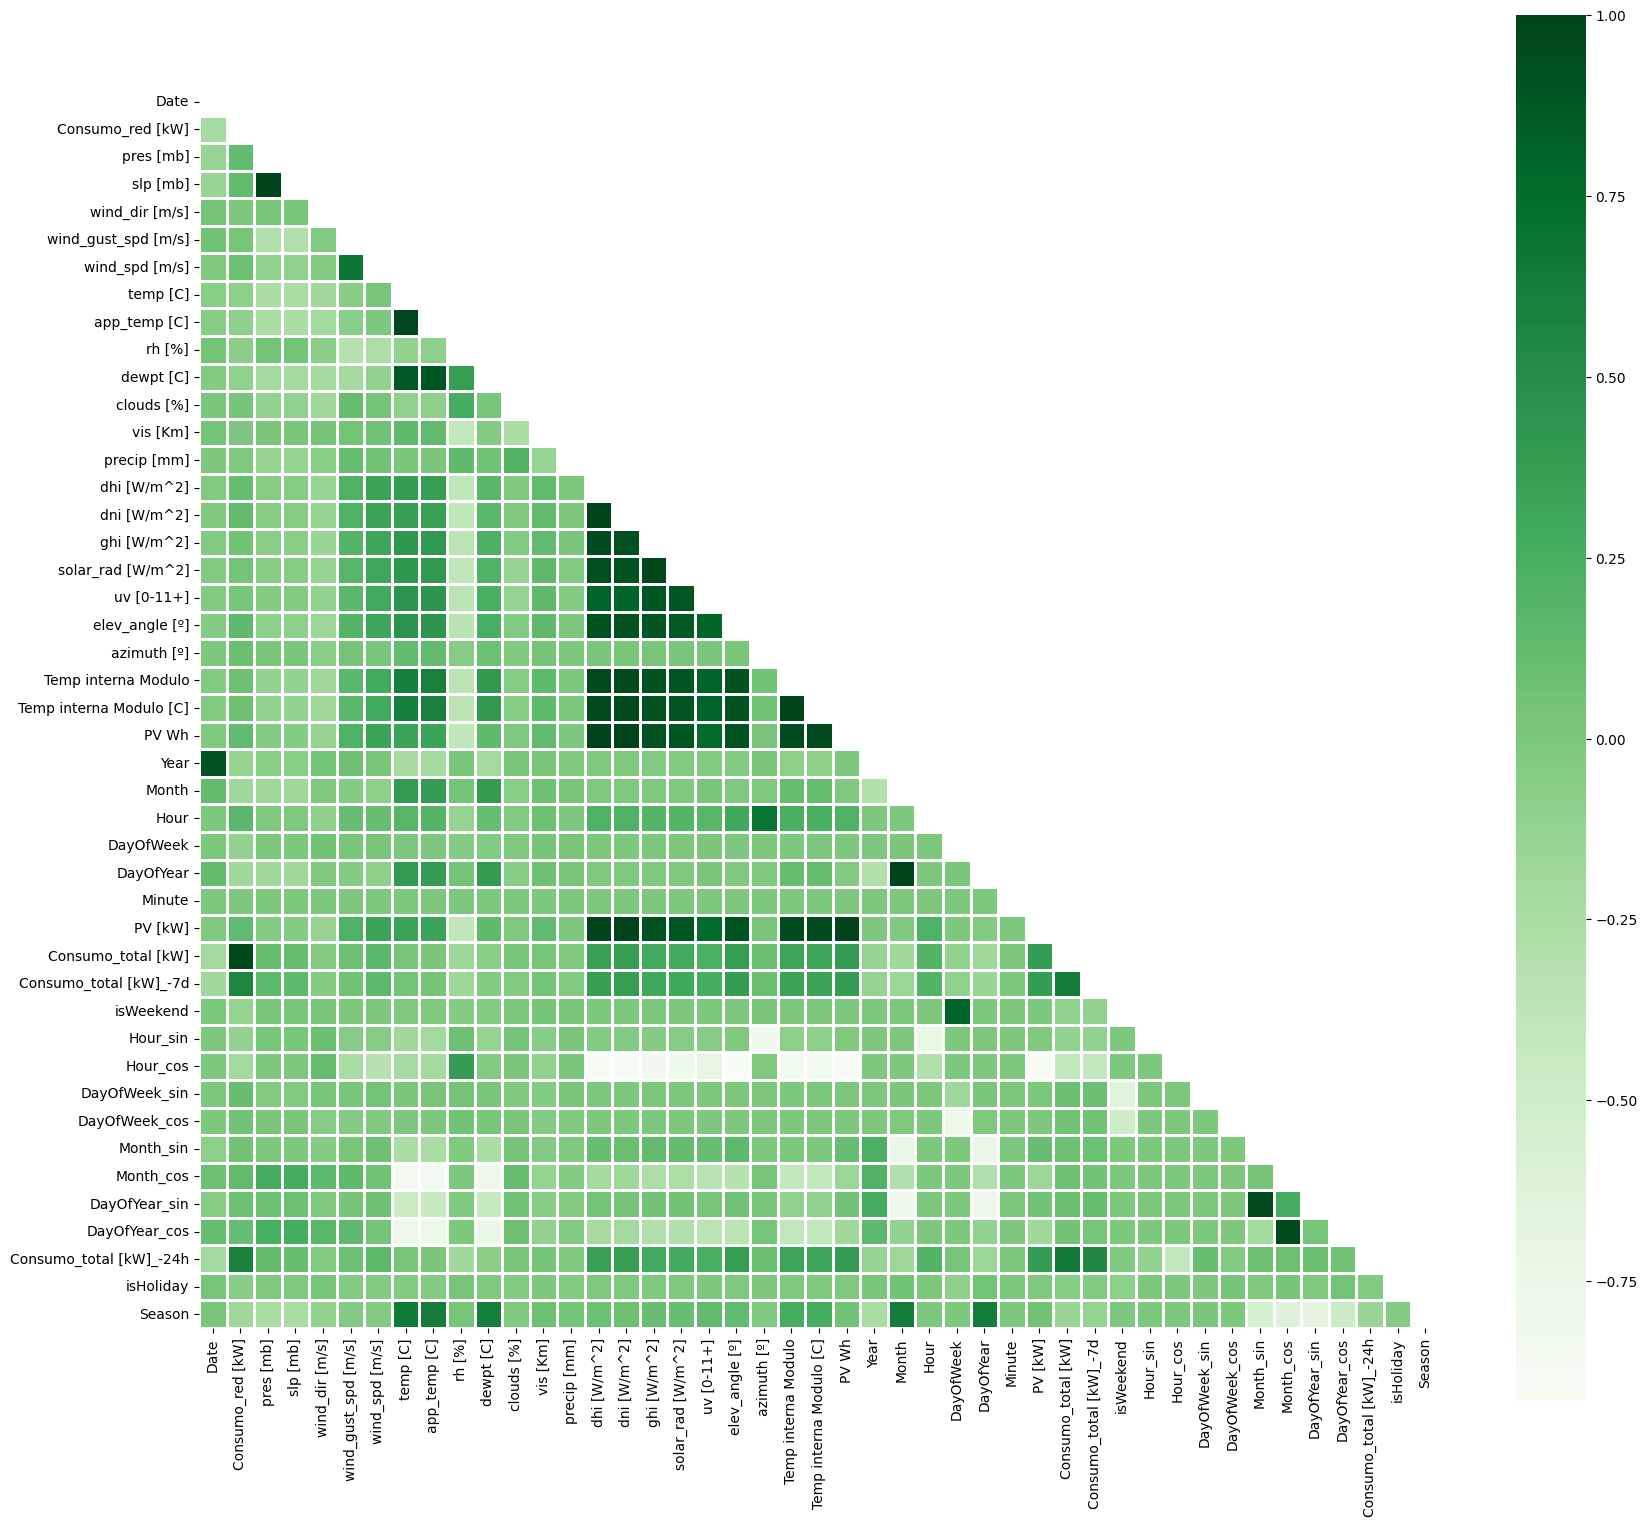

In [ ]:
# Calcula la matriz de correlación completa
correlation_matrix = df5.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Imprime la matriz de correlación del cuadrante inferior
#plotting the heatmap for correlation
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, mask=mask, square=True, cmap='Greens', linewidths=2, linecolor='white');

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



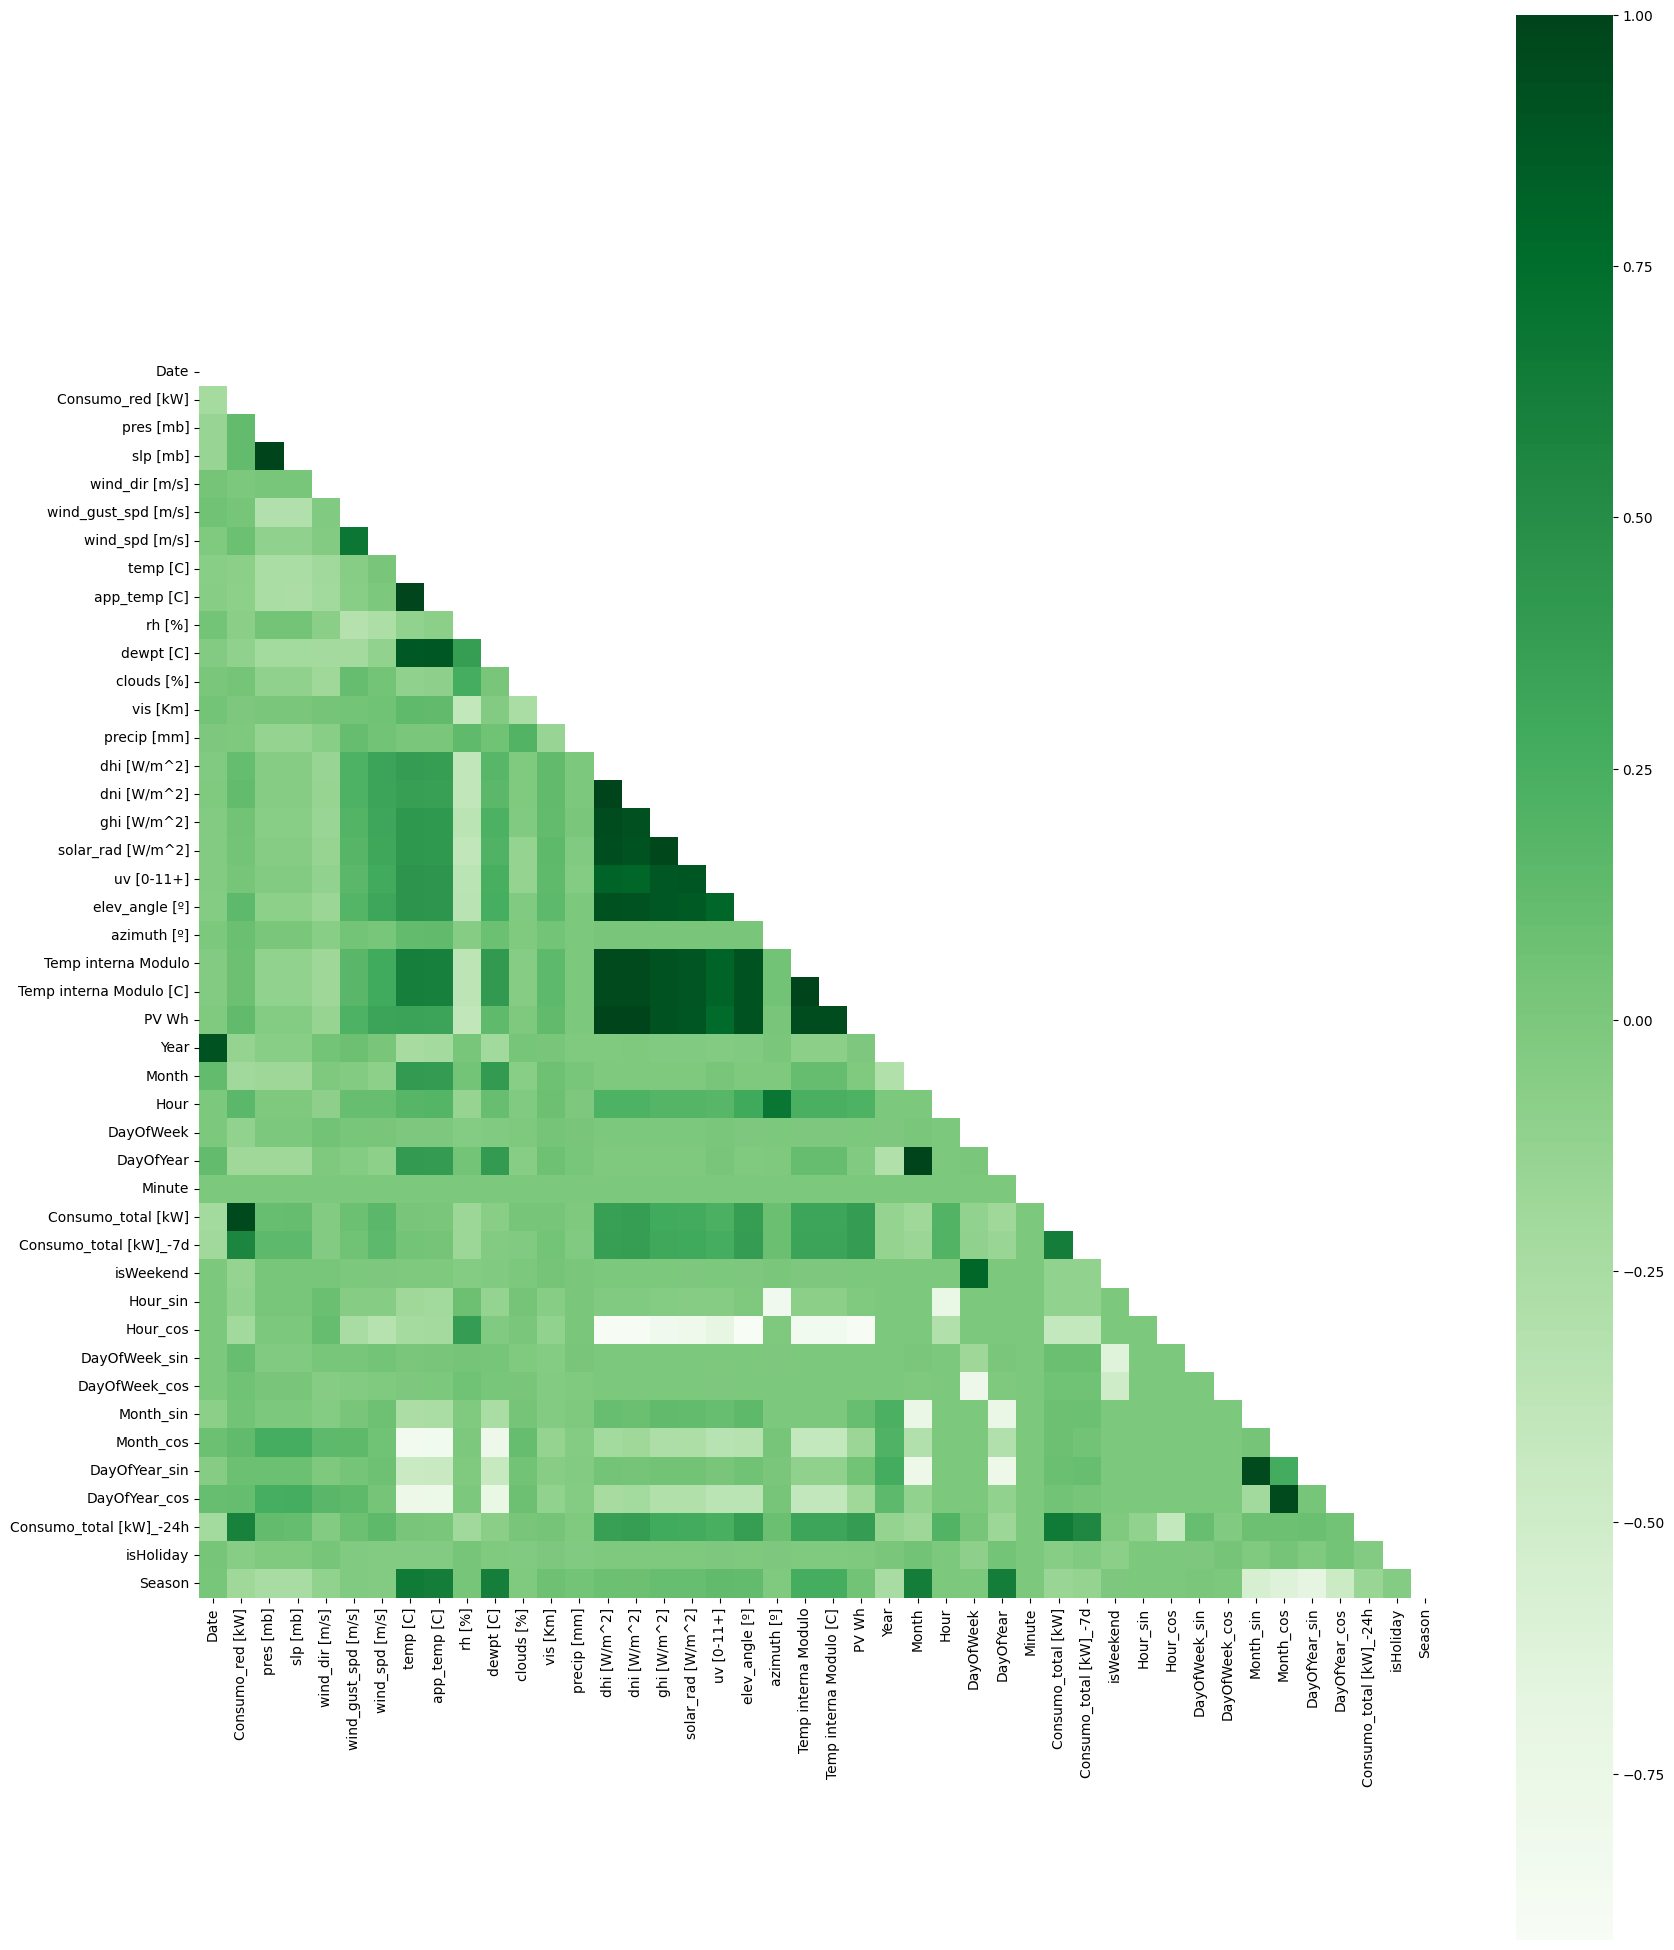

In [ ]:
# Calcula la matriz de correlación completa
df6 = df5.copy()
df6.drop(columns=["PV [kW]"], inplace=True)

correlation_matrix = df6.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Imprime la matriz de correlación del cuadrante inferior
#plotting the heatmap for correlation
plt.figure(figsize=(20, 25))
sns.heatmap(correlation_matrix, mask=mask, square=True, cmap='Greens', annot=True);

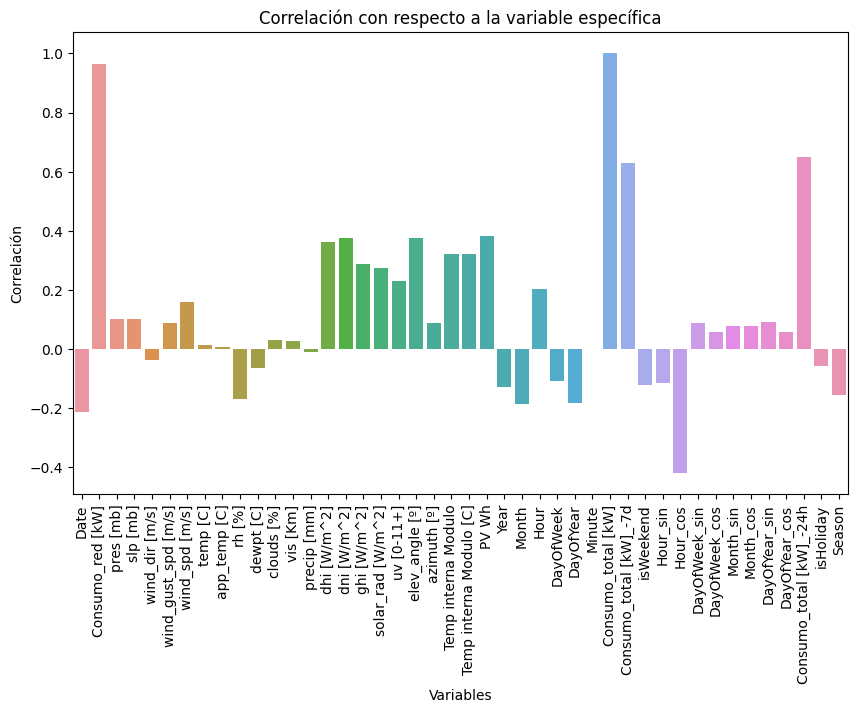

In [ ]:
# Crear un gráfico de barras de la correlación respecto a la variable específica
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_matrix.index, y=correlation_matrix['Consumo_total [kW]'])
plt.title('Correlación con respecto a la variable específica')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Guardar el DataFrame como CSV
nombre_archivo = "LaMonserratina_2022_2023_2024.csv"
ruta_completa = os.path.join(ruta_data, nombre_archivo)
df6.to_csv(ruta_completa, index=False)

## Time series decpomposition

In [ ]:

result=seasonal_decompose(df7['Consumo_total [kW]'], model='additive', period=96);  # 96 = 1 day in 15 min intervals 
result.plot()


NameError: name 'df7' is not defined

<Axes: xlabel='Date'>

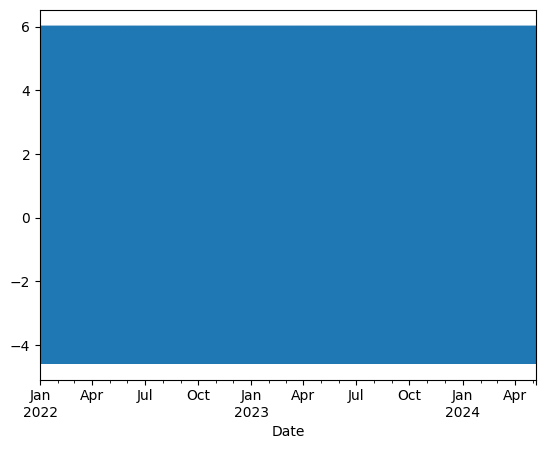

In [ ]:
result.seasonal.plot()

<Axes: xlabel='Date'>

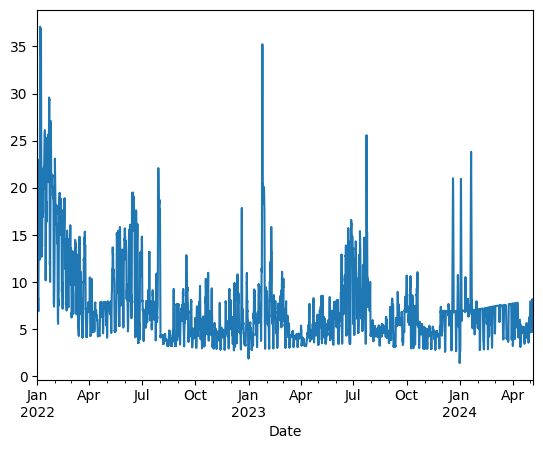

In [ ]:
result.trend.plot()

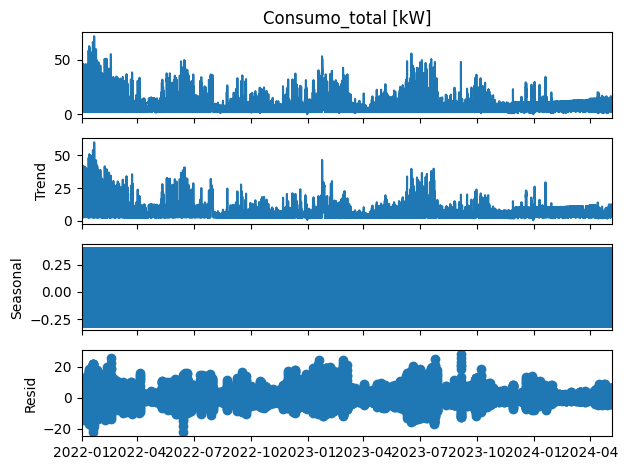

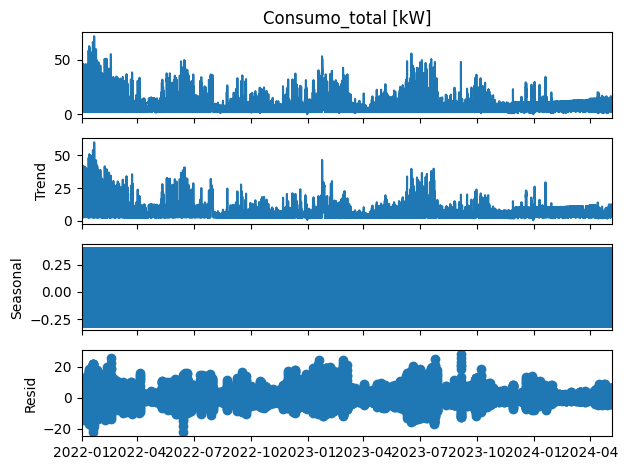

In [ ]:
result.plot()

KeyError: 'Consumo_total [kW]_trend'

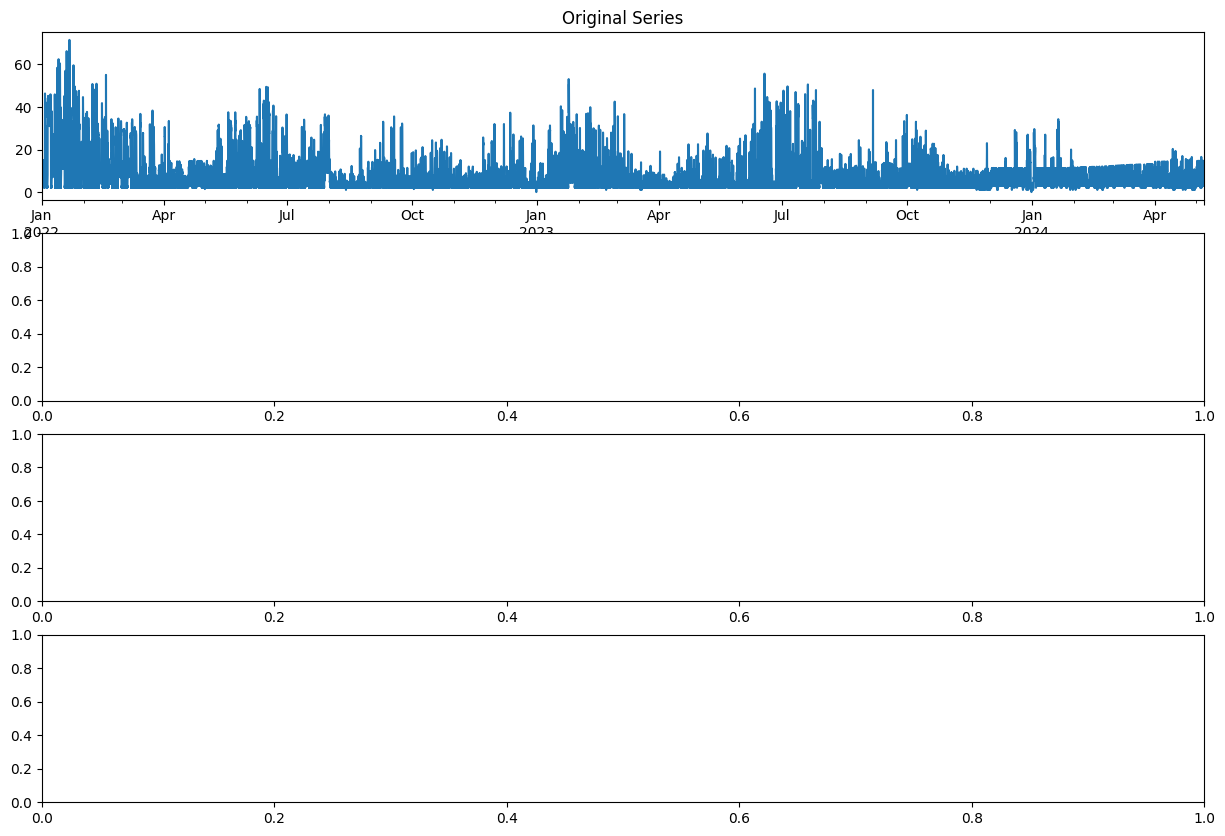

In [ ]:
def decompose_time_series(df, column, freq):
    result = seasonal_decompose(df[column], model='additive', period=freq)
    df[f"{column}_trend"] = result.trend
    df[f"{column}_seasonal"] = result.seasonal
    df[f"{column}_residual"] = result.resid
    return df

df7 = df6.copy()
df7.set_index("Date", inplace=True)
decomposed_df = decompose_time_series(df7, "Consumo_red [kW]", 1)



# Plot the decomposed time series
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
decomposed_df["Consumo_total [kW]"].plot(ax=axes[0], title="Original Series")
decomposed_df["Consumo_total [kW]_trend"].plot(ax=axes[1], title="Trend")
decomposed_df["Consumo_total [kW]_seasonal"].plot(ax=axes[2], title="Seasonal")
decomposed_df["Consumo_total [kW]_residual"].plot(ax=axes[3], title="Residual")
plt.tight_layout()

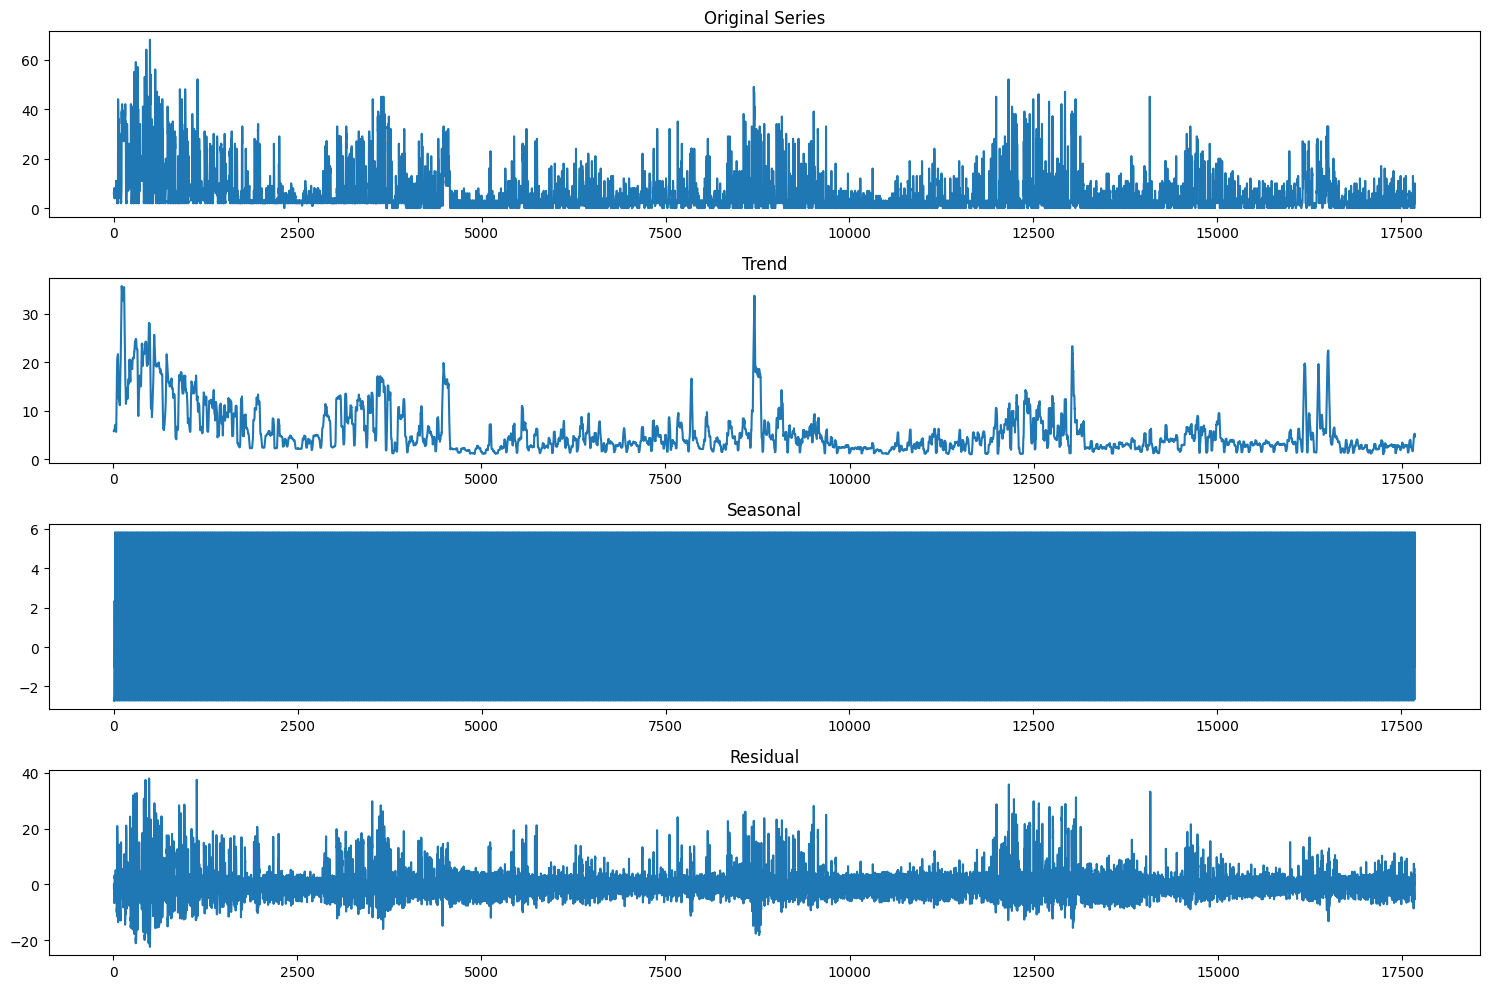

In [ ]:
def decompose_time_series(df, column, freq):
    result = seasonal_decompose(df[column], model='additive', period=freq)
    df[f"{column}_trend"] = result.trend
    df[f"{column}_seasonal"] = result.seasonal
    df[f"{column}_residual"] = result.resid
    return df


decomposed_df = decompose_time_series(df, "Consumo", 24)



# Plot the decomposed time series
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
decomposed_df["Consumo"].plot(ax=axes[0], title="Original Series")
decomposed_df["Consumo_trend"].plot(ax=axes[1], title="Trend")
decomposed_df["Consumo_seasonal"].plot(ax=axes[2], title="Seasonal")
decomposed_df["Consumo_residual"].plot(ax=axes[3], title="Residual")
plt.tight_layout()